# Setup


## Optional Google Drive integration
For storing of results, acces to google drive is recommended and needs the api token for this, also, the path, where to store the files in the drive should be set manually
set the drive path to the **EXISTING** folder in your drive, **no leading '/' required**

In [ ]:
drivePath = 'DL'

and now, run the drive setup, skip, if not wanted, the files will be stored in the mounted filesystem

In [ ]:
#run the drive setup
from google.colab import drive
driveMount = '/content/gdrive'
drive.mount(driveMount)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#test for gdrive mount
try: 
  driveMount
  print('gdrive mounted, using gdrive to store logs')
  logStorage = driveMount+'/MyDrive/'+drivePath
except:
  logStorage = None

gdrive mounted, using gdrive to store logs


## model setup
creates all functions needed to run the experiments

Set up the required libaries

In [2]:
!pip install -Uqq fastai

from fastai.vision.all import *

from fastprogress import fastprogress
from torchvision.models import *

     |████████████████████████████████| 194kB 15.9MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 


set the default parameters


In [ ]:
#parameters for the data
#use the imagewoof dataset
WOOF = True
#augment the data in a random basic way
DATA_AUGMENTATION = True
#erase parts of the images
ERASE_AUGMENTATION = False
#normalize the batch
BATCH_NORMALISATION = False

#the default Learning Rate
LEARNING_RATE = 8e-3
EPOCHS = 20

get the data

In [ ]:
#downloads the images
#first unpack the data and print some stats
if WOOF:
  path = untar_data(URLs.IMAGEWOOF)
else:
  path = untar_data(URLs.IMAGENETTE)

files = get_image_files(path/"train")
print("Training images: ", len(get_image_files(path/"train")),'(' ,np.round(len(get_image_files(path/"train"))*100/len(get_image_files(path)),2), '%)')
print("Validation images: ", len(get_image_files(path/"val")),'(' ,np.round(len(get_image_files(path/"val"))*100/len(get_image_files(path)),2), '%)')


Training images:  9025 ( 69.67 %)
Validation images:  3929 ( 30.33 %)


label data

In [ ]:
#create dict to show better readable labels
if WOOF:
  lbl_dict = dict(
      n02086240= 'Shih-Tzu',
      n02087394= 'Rhodesian ridgeback',
      n02088364= 'Beagle',
      n02089973= 'English foxhound',
      n02093754= 'Australian terrier',
      n02096294= 'Border terrier',
      n02099601= 'Golden retriever',
      n02105641= 'Old English sheepdog',
      n02111889= 'Samoyed',
      n02115641= 'Dingo'
    )
else:
  lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
  )
#function to return human readable filenames
def label_func(fname):
  return lbl_dict[parent_label(fname)]

create model with its training and learning paarmeters

In [ ]:
def create_model():
  #define the used model (here an optimized xresnet50)
  model = xresnext50(n_out=10, sa=True, pool=MaxPool)

  #add further layers here
  #model.fc = nn.Sequential(    
  #)
  global optimizer
  #the used optimization function, here ranger
  optimizer = partial(ranger, mom=.95, sqr_mom=.99, eps=1e-6)
  return model

converter for blurpool

In [ ]:
!pip install -Uqq kornia
import kornia
def convert_MP_to_blurMP(model, layer_type_old):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_MP_to_blurMP(module, layer_type_old)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = kornia.contrib.MaxBlurPool2d(3, True)
            model._modules[name] = layer_new

    return model

Data setup

In [ ]:
def setup_data():
  #get all the images
  fnames = get_image_files(path)
  #create a image
  PILImage.create(fnames[0])
  #create category pipeline
  tfm = Pipeline([parent_label, lbl_dict.__getitem__, Categorize(vocab = lbl_dict.values())])
  tfm(fnames[0])
  #create splitter
  split = GrandparentSplitter(valid_name='val')(fnames)
  #create dataset
  dset = Datasets(fnames, 
                  [[PILImage.create], [parent_label, lbl_dict.__getitem__, Categorize(vocab = lbl_dict.values())]],
                  splits=split)
  return dset
  print('data setup finished')

transform data, run independendly to get one dataset for all runs


In [ ]:
def create_data():
  dset = setup_data()
  #add the item transformations (just resize and crop)
  item_tfms = [RandomResizedCrop(128),ToTensor()]
  #the batch transformations (mainly normalize)
  batch_tfms = [IntToFloatTensor()]
  if DATA_AUGMENTATION:
    add_tfms = []
    if ERASE_AUGMENTATION:
      add_tfms=[RandomErasing()]
    batch_tfms = [IntToFloatTensor(),*aug_transforms(mult=2,xtra_tfms=add_tfms)]
  if BATCH_NORMALISATION:
    batch_tfms.append(Normalize.from_stats(*imagenet_stats))
        
  #create the dataloader
  global dls
  dls = dset.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=64)
  dls.show_batch()

Set up the actual learner function

In [ ]:
#additional metrics
def top_3_accuracy(input,target):
  return top_k_accuracy(input,target,k=3)

def top_2_accuracy(input,target):
  return top_k_accuracy(input,target,k=2)

def learn(blur=False, savemodelcb=False, epochs=20, lr=8e-3):
  #the filename for output
  filename = datetime.now().strftime("%Y%m%d_%H%M%S")

  #add blurpool to model, if set
  model = create_model()
  if blur:
    model = convert_MP_to_blurMP(model, nn.MaxPool2d)
    filename +='_blur'
  #set the callback
  callbacks = []
  if savemodelcb:
    callbacks = [SaveModelCallback()]
    filename+='savemodelcallback'
  #define the logger
  

  filename += str(epochs)+'epochs_'+str(lr)+'lr.csv'
  callbackLogger = [CSVLogger(fname=filename),ShowGraphCallback()]
  print('storing logs in '+filename)
    #define the learner
  learn = Learner(dls, model, opt_func=optimizer, metrics=[accuracy, top_3_accuracy,top_2_accuracy], cbs=callbacks+callbackLogger, path=logStorage)

  #do the train
  learn.fit_one_cycle(epochs, lr)
  #print the results
  learn.show_results()

# Experiments
Run the experiments with blur and savemodelcallback

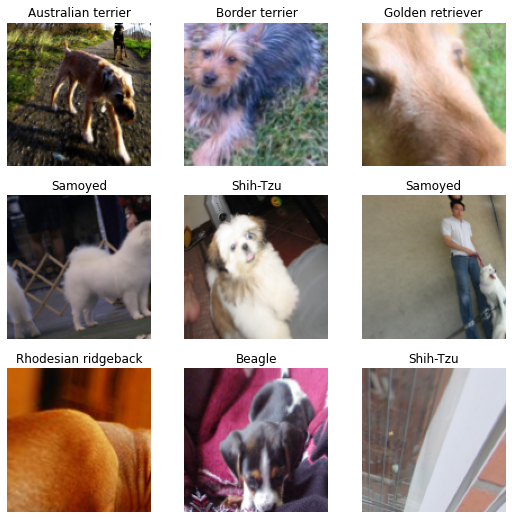

In [ ]:
#frist create the data for the models
create_data()

model without the optimisations

storing logs in model_logs20epochs_0.008lr.csv


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.043335,2.116256,0.276152,0.774752,01:24
1,2.012714,2.072091,0.291932,0.805039,01:23
2,1.964238,2.522292,0.249427,0.697887,01:24
3,1.846661,1.883860,0.370578,0.852634,01:24
4,1.687661,2.902275,0.298040,0.737592,01:24
5,1.548880,1.424569,0.489438,0.920081,01:24
6,1.415198,1.346372,0.527870,0.926444,01:24
7,1.310012,1.153161,0.620514,0.932807,01:24
8,1.200611,1.242537,0.567829,0.938661,01:24
9,1.088497,0.958816,0.672181,0.958514,01:24


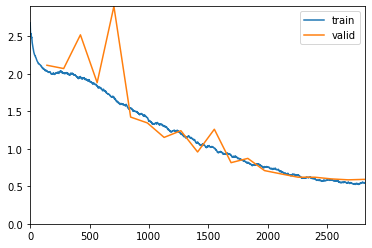

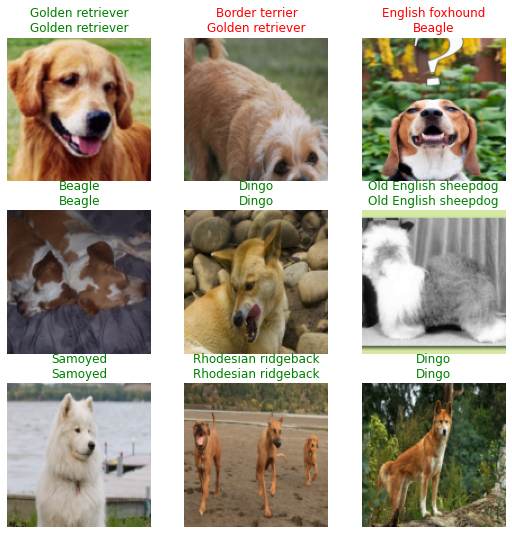

In [ ]:
learn()

model with blur

storing logs in 20210121_161646_blur40epochs_0.008lr.csv


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.073163,2.067913,0.260117,0.797149,01:26
1,2.002136,1.785812,0.373123,0.847798,01:26
2,2.013478,2.041333,0.328073,0.811657,01:26
3,1.966307,1.744901,0.374905,0.862051,01:26
4,1.856294,2.496695,0.282260,0.740392,01:26
5,1.823826,1.509215,0.458641,0.899466,01:26
6,1.724634,2.394360,0.345635,0.789514,01:26
7,1.665509,1.435636,0.492237,0.920081,01:26
8,1.579105,1.618800,0.433698,0.888012,01:26
9,1.498095,1.180955,0.599135,0.935098,01:26


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


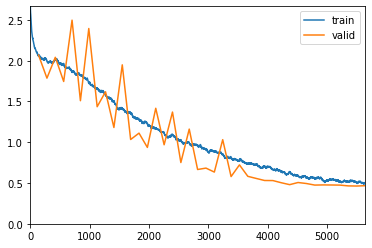

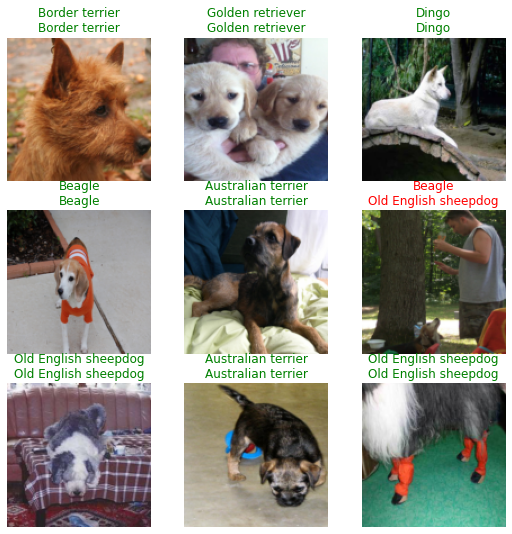

In [ ]:
learn(blur=True, epochs=40)

model with blur and savemodelcallback


storing logs in model_logs_blursavemodelcallback20epochs_0.008lr.csv


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.999137,1.982045,0.313311,0.830237,01:30
1,1.986832,1.766278,0.382540,0.856961,01:30


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Better model found at epoch 0 with valid_loss value: 1.9820451736450195.


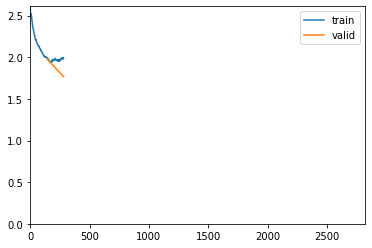

Better model found at epoch 1 with valid_loss value: 1.76627779006958.


In [ ]:
learn(blur=True, savemodelcb=True)

run it longer


storing logs in 20210121_171819_blursavemodelcallback80epochs_0.008lr.csv


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,top_2_accuracy,time
0,2.076487,1.961083,0.312039,0.630186,0.494273,01:27
1,1.982688,1.833727,0.352507,0.671418,0.546959,01:26
2,1.932496,1.822983,0.356070,0.700433,0.572665,01:27
3,1.867636,1.713699,0.398066,0.721812,0.601680,01:28
4,1.823471,1.854479,0.387630,0.690761,0.570629,01:27
5,1.779491,1.544600,0.471112,0.782133,0.673963,01:27
6,1.749848,1.918514,0.329091,0.670145,0.534996,01:28
7,1.718469,1.355595,0.531178,0.825910,0.727921,01:27
8,1.658928,2.761605,0.265462,0.564011,0.447188,01:27
9,1.595986,1.372324,0.522016,0.820056,0.713413,01:27


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Better model found at epoch 0 with valid_loss value: 1.9610825777053833.


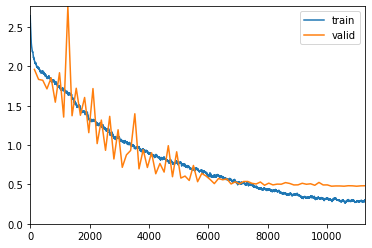

Better model found at epoch 1 with valid_loss value: 1.8337265253067017.
Better model found at epoch 2 with valid_loss value: 1.8229830265045166.
Better model found at epoch 3 with valid_loss value: 1.713699221611023.
Better model found at epoch 5 with valid_loss value: 1.5445995330810547.
Better model found at epoch 7 with valid_loss value: 1.355594515800476.
Better model found at epoch 13 with valid_loss value: 1.1574288606643677.
Better model found at epoch 15 with valid_loss value: 1.0187547206878662.
Better model found at epoch 17 with valid_loss value: 0.9334004521369934.
Better model found at epoch 19 with valid_loss value: 0.8231310248374939.
Better model found at epoch 21 with valid_loss value: 0.7173292636871338.
Better model found at epoch 25 with valid_loss value: 0.6981745362281799.
Better model found at epoch 29 with valid_loss value: 0.635708212852478.
Better model found at epoch 33 with valid_loss value: 0.5980646014213562.
Better model found at epoch 35 with valid_loss

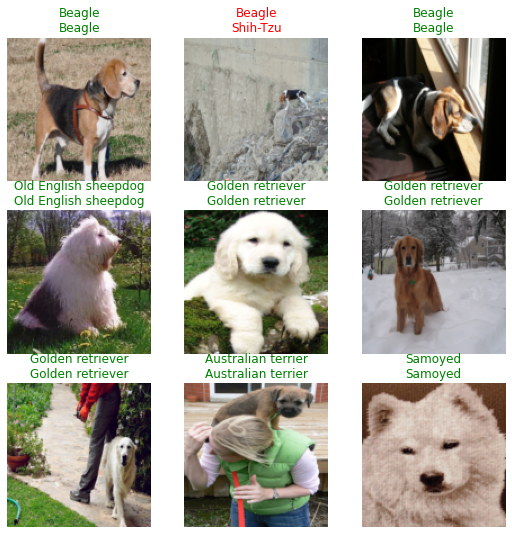

In [ ]:
learn(blur=True, savemodelcb=True, epochs=80)

and a mean test

In [ ]:
create_data()
for i in range(5):
  learn(blur=True, savemodelcb=True, epochs=80)

And the the stats

In [7]:
accuracy = array([0.878086030483245,0.877322494983673,0.879104077816009,0.876558899879455])
top3acc = array([0.969203353,0.966658175,0.967930794,0.967930794])
top2acc = array([0.94604224,0.945533216,0.945024192,0.94756937])

print("The mean accuracy is "+str(accuracy.mean()))
print("The mean top-3-accuracy is "+str(top3acc.mean()))
print("The mean top-2accuracy is "+str(top2acc.mean()))
print("")
print("The std of the accuracy is "+str(accuracy.std()))
print("The std of the top-3-accuracy is "+str(top3acc.std()))
print("The std of the top-2accuracy is "+str(top2acc.std()))


The mean accuracy is 0.8777678757905956
The mean top-3-accuracy is 0.967930779
The mean top-2accuracy is 0.9460422545

The std of the accuracy is 0.0009416269269284477
The std of the top-3-accuracy is 0.00089985631168846
The std of the top-2accuracy is 0.0009523199565979616
